_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_33 (LSTM)               (None, 1, 256)            264192    
_________________________________________________________________
lstm_34 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 789,761
Trainable params: 789,761
Non-trainable params: 0
_________________________________________________________________
None
Train on 499 samples, validate on 80 samples
Epoch 1/100
499/499 [==============================] - 5s 10ms/step - loss: 0.0151 - val_loss: 0.4819
Epoch 2/100
499/499 [==============================] - 1s 1ms/step - loss: 0.0586 - val_loss: 0.4908
Epoch 3/100
499/499 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0912
Epoch 4/100
499/499 [=========================

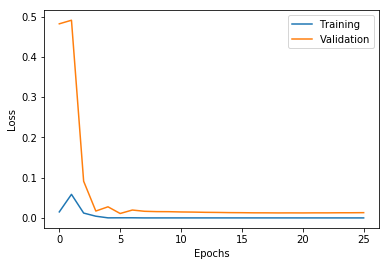

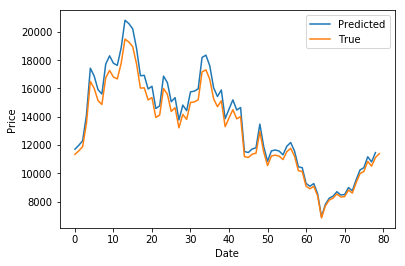

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from math import sqrt
from random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.callbacks import EarlyStopping
from keras import initializers
from matplotlib import pyplot
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline



def create_lookback(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)



bitcoin_data = pd.read_csv('cryptocurrencypricehistory/bitcoin_dataset.csv', header = 0, parse_dates=['Date'])
bitcoin_data['Year'] = bitcoin_data['Date'].apply(lambda x: x.year)
bitcoin_data['Month'] = bitcoin_data['Date'].apply(lambda x: x.month)
bitcoin_data = bitcoin_data.loc[bitcoin_data['Date'] > datetime(2016,1,1)]
bitcoin_data.head(3)

daily_price = bitcoin_data[['Date', 'btc_market_price']]
daily_price = daily_price.set_index('Date')
df_train = daily_price[200:700]
df_test = daily_price[700:]

working_data = [df_train, df_test]
working_data = pd.concat(working_data)

working_data = working_data.reset_index()
working_data['date'] = pd.to_datetime(working_data['Date'])
working_data = working_data.set_index('Date')


training_set = df_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
test_set = df_test.values
test_set = np.reshape(test_set, (len(test_set), 1))

# scale datasets
scaler = MinMaxScaler()
training_set = scaler.fit_transform(training_set)
test_set = scaler.transform(test_set)

# create datasets which are suitable for time series forecasting
look_back = 1
X_train, Y_train = create_lookback(training_set, look_back)
X_test, Y_test = create_lookback(test_set, look_back)

# reshape datasets so that they will be ok for the requirements of the LSTM model in Keras
X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(256))
model.add(Dense(1))

print(model.summary())

# compile and fit the model
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, shuffle=False,
                    validation_data=(X_test, Y_test),
                    callbacks = [EarlyStopping(monitor='val_loss', min_delta=5e-5, patience=20, verbose=1)])

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

# get predictions and then make some transformations to be able to calculate RMSE properly in USD
prediction = model.predict(X_test)
prediction_inverse = scaler.inverse_transform(prediction.reshape(-1, 1))
Y_test_inverse = scaler.inverse_transform(Y_test.reshape(-1, 1))
prediction2_inverse = np.array(prediction_inverse[:,0][1:])
Y_test2_inverse = np.array(Y_test_inverse[:,0])

plt.figure()
plt.xlabel('Date')
plt.ylabel('Price')
plt.plot(prediction2_inverse)
plt.plot(Y_test2_inverse)
plt.legend(['Predicted', 'True'])

loss = model.evaluate(np.array(X_test), np.array(Y_test), verbose=0)
print('Test Loss:', loss)